In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:

# Load the CSV file and filter numeric columns
data = pd.read_csv(r'DJIFlightRecord_2024-10-17_[13-51-44].csv', low_memory=False)

print(data.columns)
print(data.info())

Index(['CUSTOM.date [local]', 'CUSTOM.updateTime [local]', 'OSD.flyTime',
       'OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude', 'OSD.height [ft]',
       'OSD.heightMax [ft]', 'OSD.vpsHeight [ft]', 'OSD.altitude [ft]',
       ...
       'SERIAL.flightController', 'SERIAL.camera', 'SERIAL.gimbal',
       'SERIAL.rc', 'SERIAL.battery', 'APPGPS.latitude', 'APPGPS.longitude',
       'APPGPS.accuracy', 'APP.tip', 'APP.warning'],
      dtype='object', length=192)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Columns: 192 entries, CUSTOM.date [local] to APP.warning
dtypes: bool(58), float64(83), int64(16), object(35)
memory usage: 7.9+ MB
None


In [24]:
import pandas as pd

# Load the original dataset
data = pd.read_csv('DJIFlightRecord_2024-10-17_[13-51-44].csv')

# List of selected columns for trajectory prediction
selected_columns = [
    #time
    'OSD.flyTime [s]',
    # Position and Orientation
    'OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]', 'OSD.height [ft]', 'OSD.vpsHeight [ft]',
    'HOME.latitude', 'HOME.longitude', 'HOME.height [ft]', 'OSD.pitch', 'OSD.roll', 'OSD.yaw',
    'GIMBAL.pitch', 'GIMBAL.roll', 'GIMBAL.yaw',
    
    # Velocity and Speed
    'OSD.hSpeed [MPH]', 'OSD.xSpeed [MPH]', 'OSD.ySpeed [MPH]', 'OSD.zSpeed [MPH]',
    'OSD.hSpeedMax [MPH]', 'OSD.xSpeedMax [MPH]', 'OSD.ySpeedMax [MPH]', 'OSD.zSpeedMax [MPH]',
    
    # Time and Date
    'CUSTOM.date [local]', 'CUSTOM.updateTime [local]', 'OSD.flyTime [s]', 'DETAILS.totalTime [s]', 'DETAILS.totalDistance [ft]',
    
    # Battery and Power
    'BATTERY.chargeLevel', 'BATTERY.currentCapacity [mAh]', 'BATTERY.fullCapacity [mAh]', 'BATTERY.voltage [V]',
    'BATTERY.isVoltageLow', 'BATTERY.lowWarning', 'BATTERY.seriousLowWarning',
    
    # Environmental Conditions
    'WEATHER.windDirection', 'WEATHER.windSpeed [MPH]', 'WEATHER.windStrength', 'BATTERY.temperature [F]',
    
    # GPS and Satellite Information
    'OSD.gpsLevel', 'OSD.gpsNum', 'APPGPS.accuracy', 'APPGPS.latitude', 'APPGPS.longitude',
    
    # Home and RTH Information
    'HOME.goHomeMode', 'HOME.distance [ft]',
    
    # Control and Operational States
    'OSD.flycState', 'OSD.flycCommand', 'OSD.flightAction', 'MC.isObstacleAvoidanceEnabled', 'MC.isBraking'
]

# Create a new DataFrame with only the selected columns
new_df = data[selected_columns]

# Save the new DataFrame to a new CSV file
new_df.to_csv('trajectory_prediction_data.csv', index=False)

print("New dataset saved as 'trajectory_prediction_data.csv'")


New dataset saved as 'trajectory_prediction_data.csv'


C:\Users\vines\AppData\Local\Temp\ipykernel_21824\2100459725.py:4: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('DJIFlightRecord_2024-10-17_[13-51-44].csv')


In [25]:
df = pd.read_csv(r'trajectory_prediction_data.csv', low_memory=False)

In [ ]:

#df = data.select_dtypes(include=[float, int,object])# Filter numerical and string only bool not usefull checked in below code
#df=df.select_dtypes(include=[object,bool])
print(df.columns)
print(df.dtypes)



Index(['OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]',
       'OSD.height [ft]', 'OSD.vpsHeight [ft]', 'HOME.latitude',
       'HOME.longitude', 'HOME.height [ft]', 'OSD.pitch', 'OSD.roll',
       'OSD.yaw', 'GIMBAL.pitch', 'GIMBAL.roll', 'GIMBAL.yaw',
       'OSD.hSpeed [MPH]', 'OSD.xSpeed [MPH]', 'OSD.ySpeed [MPH]',
       'OSD.zSpeed [MPH]', 'OSD.hSpeedMax [MPH]', 'OSD.xSpeedMax [MPH]',
       'OSD.ySpeedMax [MPH]', 'OSD.zSpeedMax [MPH]', 'CUSTOM.date [local]',
       'CUSTOM.updateTime [local]', 'OSD.flyTime [s].1',
       'DETAILS.totalTime [s]', 'DETAILS.totalDistance [ft]',
       'BATTERY.chargeLevel', 'BATTERY.currentCapacity [mAh]',
       'BATTERY.fullCapacity [mAh]', 'BATTERY.voltage [V]',
       'BATTERY.isVoltageLow', 'BATTERY.lowWarning',
       'BATTERY.seriousLowWarning', 'WEATHER.windDirection',
       'WEATHER.windSpeed [MPH]', 'WEATHER.windStrength',
       'BATTERY.temperature [F]', 'OSD.gpsLevel', 'OSD.gpsNum',
       'APPGPS.accuracy', 'A

In [27]:
df['OSD.flightAction'].unique()
df['OSD.flycCommand'].unique() 
df['OSD.flycState'].unique()  
df['WEATHER.windDirection'].unique() 
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to columns (in place)
df['WEATHER.windDirection'] = label_encoder.fit_transform(df['WEATHER.windDirection'])
df['OSD.flycState'] = label_encoder.fit_transform(df['OSD.flycState'])
df['OSD.flycCommand'] = label_encoder.fit_transform(df['OSD.flycCommand'])
df['OSD.flightAction'] = label_encoder.fit_transform(df['OSD.flightAction'])
import pickle

# Save label encoders for future use
with open('label_encoder_flycState.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
# Basic data inspection
print(df.columns)
print("Data Information:")
df.info()
print("\nData Description:")
print(df.describe())  # Basic statistics to understand ranges and distributions
print("\nFirst few rows:")
print(df.head())

Index(['OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]',
       'OSD.height [ft]', 'OSD.vpsHeight [ft]', 'HOME.latitude',
       'HOME.longitude', 'HOME.height [ft]', 'OSD.pitch', 'OSD.roll',
       'OSD.yaw', 'GIMBAL.pitch', 'GIMBAL.roll', 'GIMBAL.yaw',
       'OSD.hSpeed [MPH]', 'OSD.xSpeed [MPH]', 'OSD.ySpeed [MPH]',
       'OSD.zSpeed [MPH]', 'OSD.hSpeedMax [MPH]', 'OSD.xSpeedMax [MPH]',
       'OSD.ySpeedMax [MPH]', 'OSD.zSpeedMax [MPH]', 'CUSTOM.date [local]',
       'CUSTOM.updateTime [local]', 'OSD.flyTime [s].1',
       'DETAILS.totalTime [s]', 'DETAILS.totalDistance [ft]',
       'BATTERY.chargeLevel', 'BATTERY.currentCapacity [mAh]',
       'BATTERY.fullCapacity [mAh]', 'BATTERY.voltage [V]',
       'BATTERY.isVoltageLow', 'BATTERY.lowWarning',
       'BATTERY.seriousLowWarning', 'WEATHER.windDirection',
       'WEATHER.windSpeed [MPH]', 'WEATHER.windStrength',
       'BATTERY.temperature [F]', 'OSD.gpsLevel', 'OSD.gpsNum',
       'APPGPS.accuracy', 'A

In [29]:
df.dtypes
print(df.columns)

Index(['OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]',
       'OSD.height [ft]', 'OSD.vpsHeight [ft]', 'HOME.latitude',
       'HOME.longitude', 'HOME.height [ft]', 'OSD.pitch', 'OSD.roll',
       'OSD.yaw', 'GIMBAL.pitch', 'GIMBAL.roll', 'GIMBAL.yaw',
       'OSD.hSpeed [MPH]', 'OSD.xSpeed [MPH]', 'OSD.ySpeed [MPH]',
       'OSD.zSpeed [MPH]', 'OSD.hSpeedMax [MPH]', 'OSD.xSpeedMax [MPH]',
       'OSD.ySpeedMax [MPH]', 'OSD.zSpeedMax [MPH]', 'CUSTOM.date [local]',
       'CUSTOM.updateTime [local]', 'OSD.flyTime [s].1',
       'DETAILS.totalTime [s]', 'DETAILS.totalDistance [ft]',
       'BATTERY.chargeLevel', 'BATTERY.currentCapacity [mAh]',
       'BATTERY.fullCapacity [mAh]', 'BATTERY.voltage [V]',
       'BATTERY.isVoltageLow', 'BATTERY.lowWarning',
       'BATTERY.seriousLowWarning', 'WEATHER.windDirection',
       'WEATHER.windSpeed [MPH]', 'WEATHER.windStrength',
       'BATTERY.temperature [F]', 'OSD.gpsLevel', 'OSD.gpsNum',
       'APPGPS.accuracy', 'A

In [56]:
import numpy as np
df_numeric=df.select_dtypes(include=[np.number])
df=df_numeric
print(df.dtypes)
print(df.columns)
print(df['OSD.flyTime [s]'])
print(df.info())


OSD.flyTime [s]                  float64
OSD.latitude                     float64
OSD.longitude                    float64
OSD.altitude [ft]                  int64
OSD.height [ft]                  float64
OSD.vpsHeight [ft]               float64
HOME.latitude                    float64
HOME.longitude                   float64
HOME.height [ft]                 float64
OSD.pitch                        float64
OSD.roll                         float64
OSD.yaw                          float64
GIMBAL.pitch                     float64
GIMBAL.roll                      float64
GIMBAL.yaw                       float64
OSD.hSpeed [MPH]                 float64
OSD.xSpeed [MPH]                 float64
OSD.ySpeed [MPH]                 float64
OSD.zSpeed [MPH]                 float64
OSD.hSpeedMax [MPH]              float64
OSD.xSpeedMax [MPH]              float64
OSD.ySpeedMax [MPH]              float64
OSD.zSpeedMax [MPH]              float64
OSD.flyTime [s].1                float64
DETAILS.totalTim

In [ ]:
'''
# %% Import libraries

df = data.select_dtypes(include=[object,bool])# Filter only object columns


df['OSD.flightAction'].unique()
df['OSD.flycCommand'].unique() 
df['OSD.flycState'].unique()  

df['WEATHER.windDirection'].unique() 
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to columns (in place)
df['WEATHER.windDirection'] = label_encoder.fit_transform(df['WEATHER.windDirection'])
df['OSD.flycState'] = label_encoder.fit_transform(df['OSD.flycState'])
df['OSD.flycCommand'] = label_encoder.fit_transform(df['OSD.flycCommand'])
df['OSD.flightAction'] = label_encoder.fit_transform(df['OSD.flightAction'])
import pickle

# Save label encoders for future use
with open('label_encoder_flycState.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
df['BATTERY.isVoltageLow'].unique()   
df['MC.isObstacleAvoidanceEnabled'].unique()  
df['MC.isBraking'].unique() 
# Basic data inspection
print("Data Information:")
df.info()
print("\nData Description:")
print(df.describe())  # Basic statistics to understand ranges and distributions
print("\nFirst few rows:")
print(df.head())'''

'\n# %% Import libraries\n\ndf = data.select_dtypes(include=[object,bool])# Filter only object columns\n\n# Basic data inspection\nprint("Data Information:")\ndf.info()\nprint("\nData Description:")\nprint(df.describe())  # Basic statistics to understand ranges and distributions\nprint("\nFirst few rows:")\nprint(df.head())\ndf[\'OSD.flightAction\'].unique()\ndf[\'OSD.flycCommand\'].unique() \ndf[\'OSD.flycState\'].unique()  \n\ndf[\'WEATHER.windDirection\'].unique() \nfrom sklearn.preprocessing import LabelEncoder\n\n# Initialize LabelEncoder\nlabel_encoder = LabelEncoder()\n\n# Apply label encoding to columns (in place)\ndf[\'WEATHER.windDirection\'] = label_encoder.fit_transform(df[\'WEATHER.windDirection\'])\ndf[\'OSD.flycState\'] = label_encoder.fit_transform(df[\'OSD.flycState\'])\ndf[\'OSD.flycCommand\'] = label_encoder.fit_transform(df[\'OSD.flycCommand\'])\ndf[\'OSD.flightAction\'] = label_encoder.fit_transform(df[\'OSD.flightAction\'])\nimport pickle\n\n# Save label encoders 


Total Missing Values in Dataset: 36892


<Axes: >

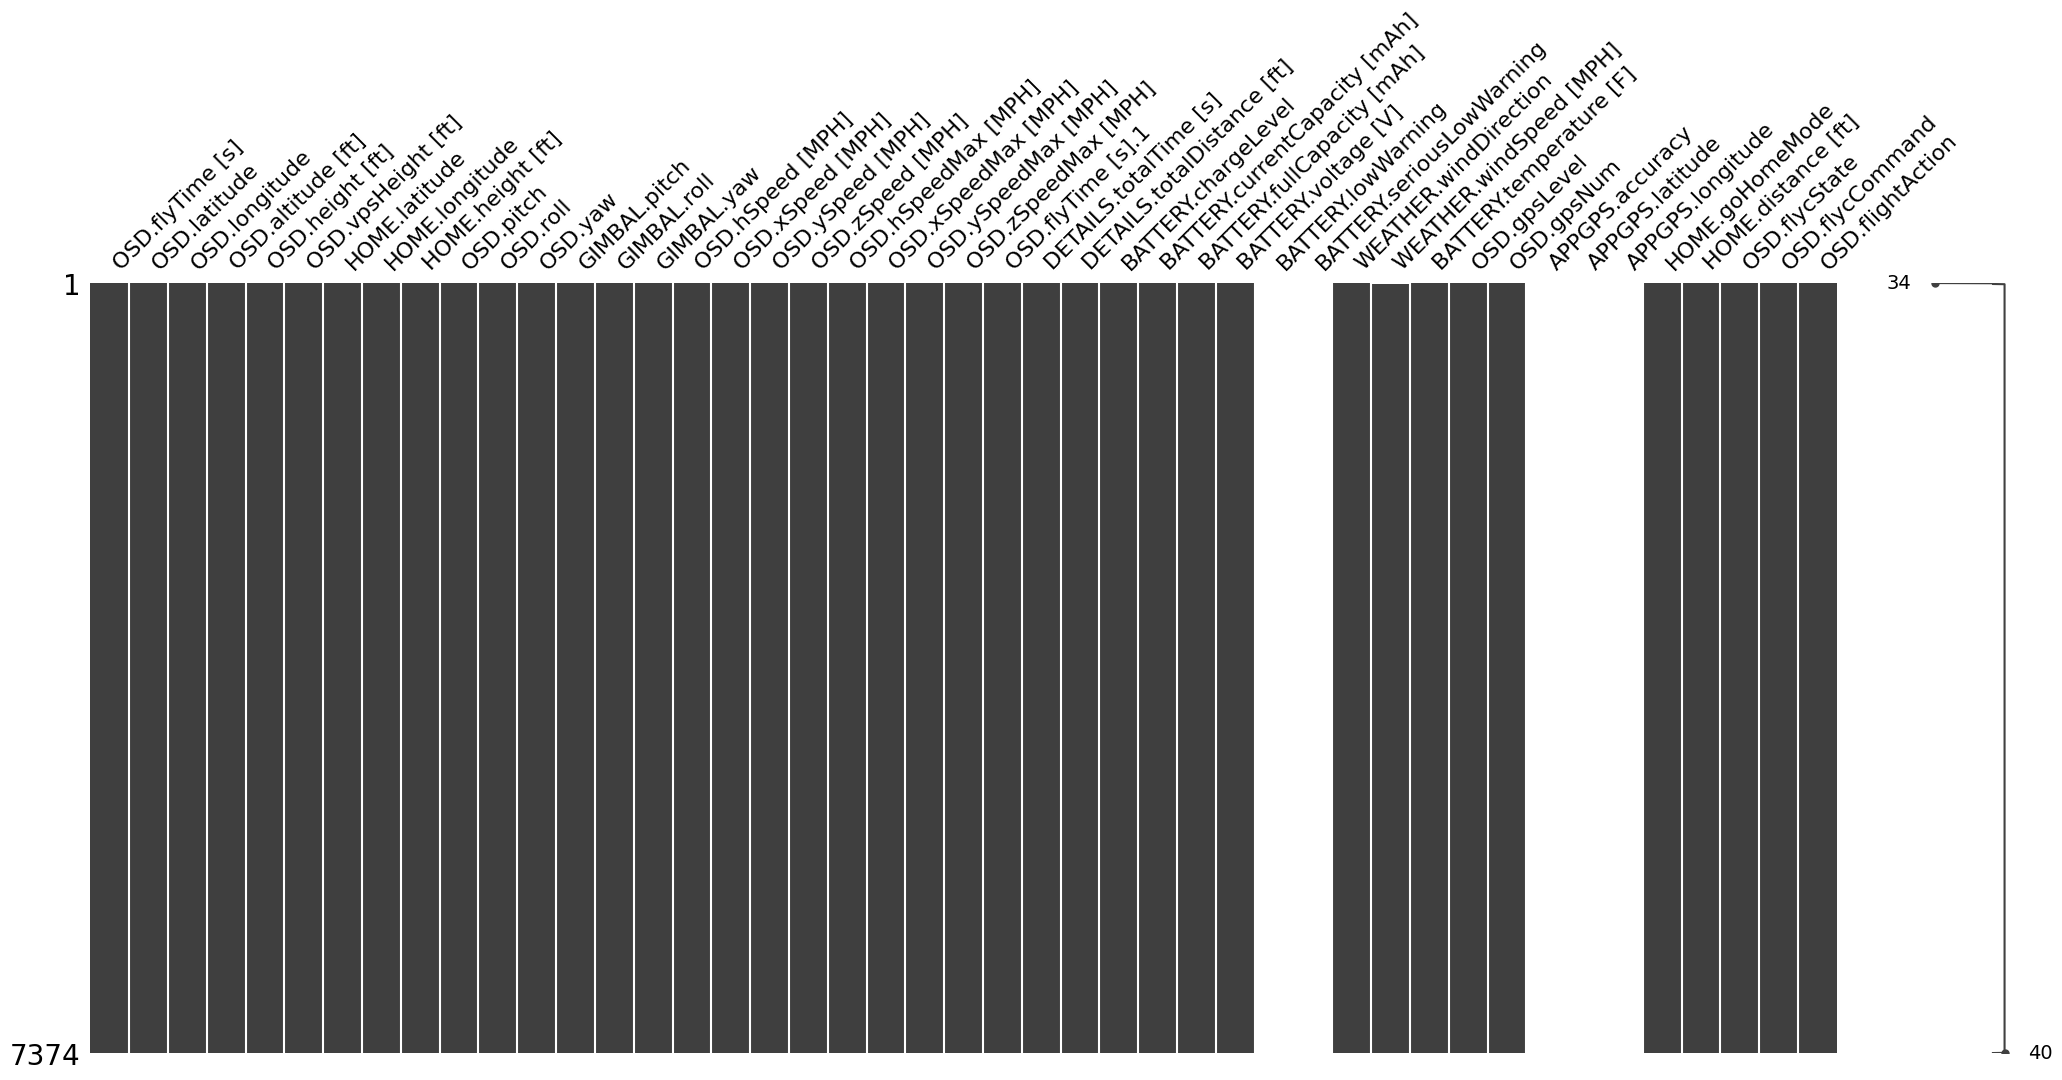

In [32]:
# %% Check for missing values
nan_counts = df.isnull().sum()
total_nan_count = nan_counts.sum()
print(f"\nTotal Missing Values in Dataset: {total_nan_count}")

import missingno as msno

# Visualize missing data
msno.matrix(df)

In [33]:
# Identify and drop columns with 100% null values
columns_with_all_nulls = nan_counts[nan_counts == len(df)].index


# Identify and drop columns with more than 50% null values
threshold = len(df) / 2

columns_with_many_nulls = nan_counts[nan_counts > threshold].index
df = df.drop(columns=columns_with_many_nulls)

print("\nDataFrame after dropping columns with many null values:")
print(df.info())  # Re-check DataFrame info after cleaning




DataFrame after dropping columns with many null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSD.flyTime [s]                7374 non-null   float64
 1   OSD.latitude                   7374 non-null   float64
 2   OSD.longitude                  7374 non-null   float64
 3   OSD.altitude [ft]              7374 non-null   int64  
 4   OSD.height [ft]                7374 non-null   float64
 5   OSD.vpsHeight [ft]             7374 non-null   float64
 6   HOME.latitude                  7372 non-null   float64
 7   HOME.longitude                 7372 non-null   float64
 8   HOME.height [ft]               7372 non-null   float64
 9   OSD.pitch                      7374 non-null   float64
 10  OSD.roll                       7374 non-null   float64
 11  OSD.yaw                        7374 non-null   floa

In [34]:
columns_with_all_nulls = df.columns[df.isnull().mean() == 1.0]

# Print the columns with 100% null values
print("Columns with 100% null values:")
print(columns_with_all_nulls)

# Count the number of columns with 100% null values
count_all_nulls = len(columns_with_all_nulls)
print("\nNumber of columns with 100% null values:")
print(count_all_nulls)
print("\nDataFrame after dropping columns with many null values:")
print(df.info())  # Re-check DataFrame info after cleaning

Columns with 100% null values:
Index([], dtype='object')

Number of columns with 100% null values:
0

DataFrame after dropping columns with many null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSD.flyTime [s]                7374 non-null   float64
 1   OSD.latitude                   7374 non-null   float64
 2   OSD.longitude                  7374 non-null   float64
 3   OSD.altitude [ft]              7374 non-null   int64  
 4   OSD.height [ft]                7374 non-null   float64
 5   OSD.vpsHeight [ft]             7374 non-null   float64
 6   HOME.latitude                  7372 non-null   float64
 7   HOME.longitude                 7372 non-null   float64
 8   HOME.height [ft]               7372 non-null   float64
 9   OSD.pitch                      7374 non-null   float64
 10  OSD.roll  


Total Missing Values in Dataset: 22


<Axes: >

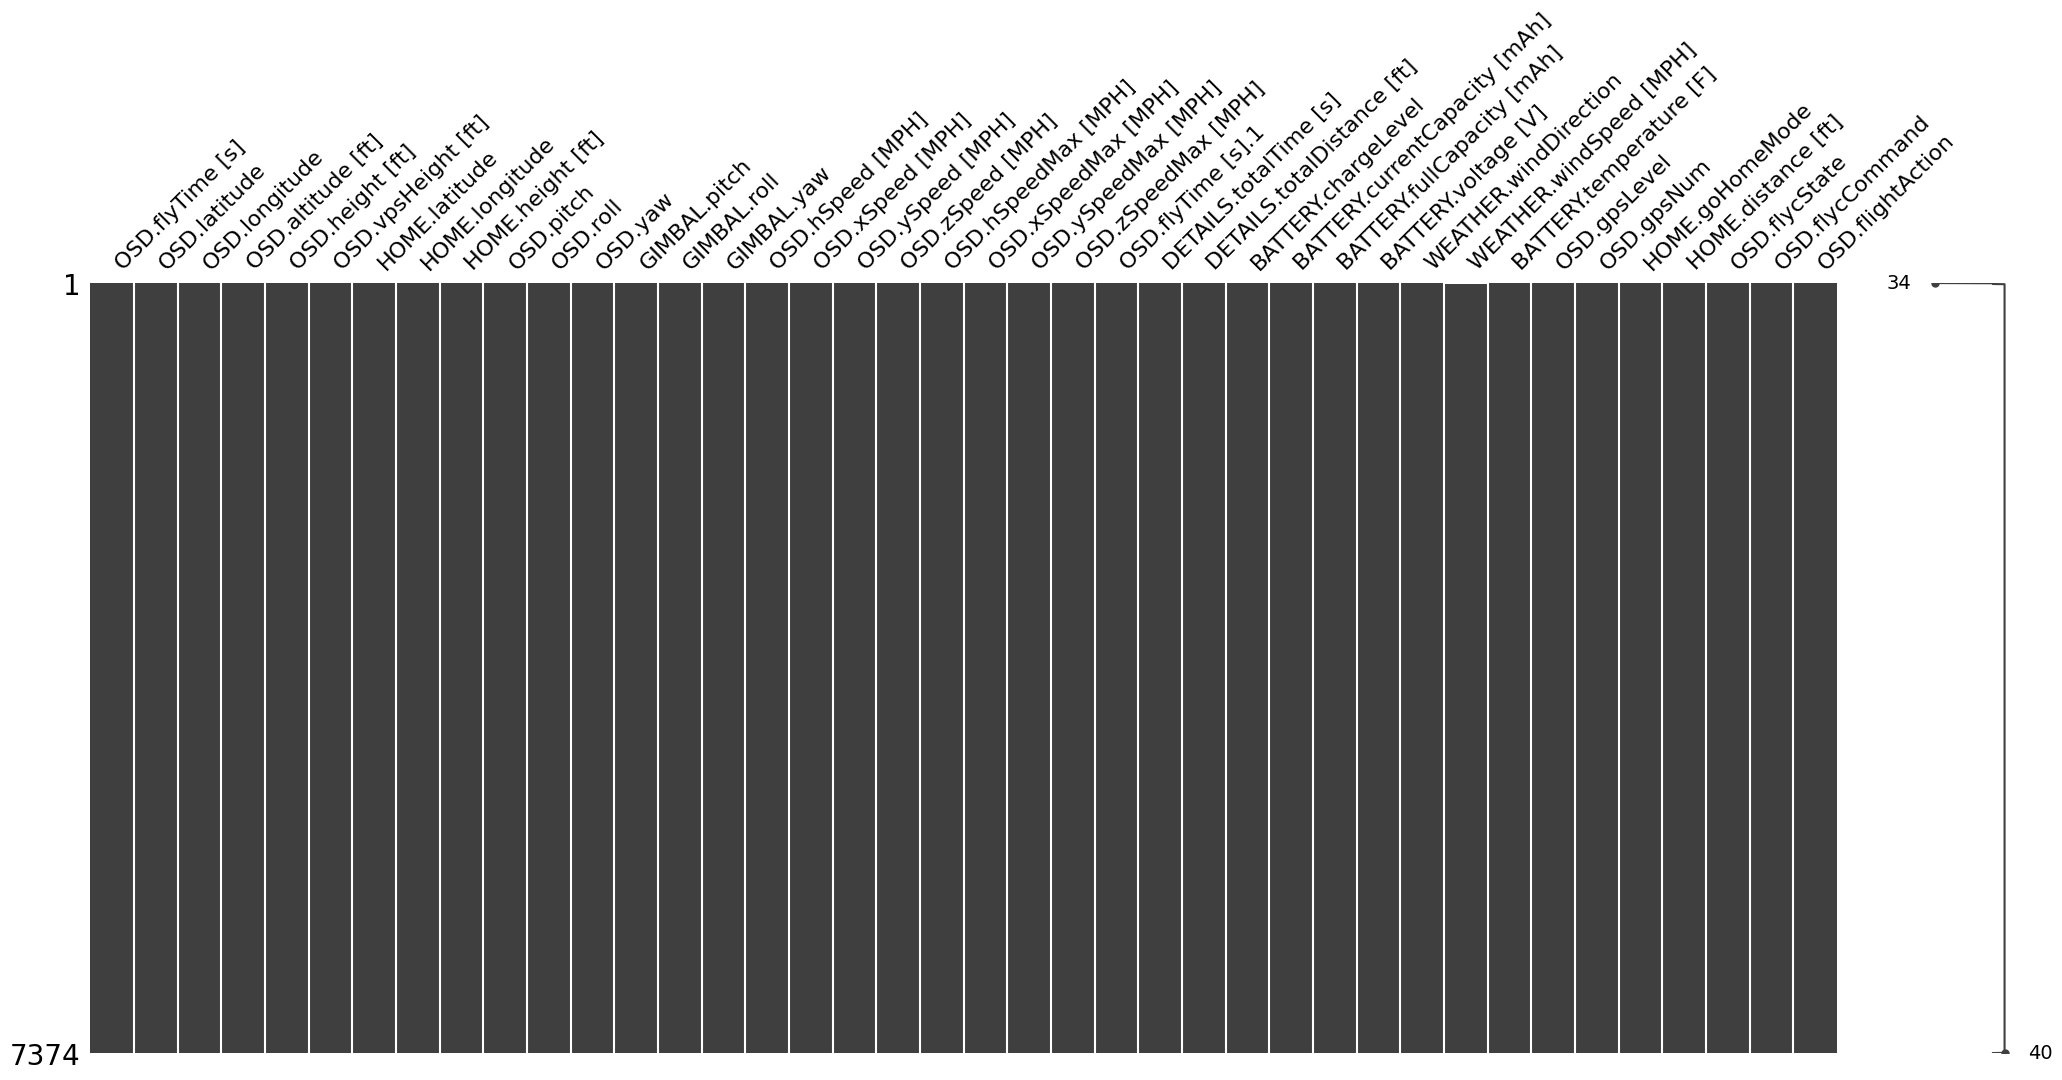

In [35]:
# %% Check for missing values
nan_counts = df.isnull().sum()
total_nan_count = nan_counts.sum()
print(f"\nTotal Missing Values in Dataset: {total_nan_count}")

import missingno as msno

# Visualize missing data
msno.matrix(df)

In [36]:
nan = df.isnull().sum()
print(nan)

OSD.flyTime [s]                   0
OSD.latitude                      0
OSD.longitude                     0
OSD.altitude [ft]                 0
OSD.height [ft]                   0
OSD.vpsHeight [ft]                0
HOME.latitude                     2
HOME.longitude                    2
HOME.height [ft]                  2
OSD.pitch                         0
OSD.roll                          0
OSD.yaw                           0
GIMBAL.pitch                      0
GIMBAL.roll                       0
GIMBAL.yaw                        0
OSD.hSpeed [MPH]                  0
OSD.xSpeed [MPH]                  0
OSD.ySpeed [MPH]                  0
OSD.zSpeed [MPH]                  0
OSD.hSpeedMax [MPH]               0
OSD.xSpeedMax [MPH]               0
OSD.ySpeedMax [MPH]               0
OSD.zSpeedMax [MPH]               0
OSD.flyTime [s].1                 0
DETAILS.totalTime [s]             0
DETAILS.totalDistance [ft]        0
BATTERY.chargeLevel               0
BATTERY.currentCapacity [mAh

In [37]:
# %% Impute remaining missing values
df = df.fillna(method='ffill').fillna(method='bfill')  # Forward fill, then backward fill
remaining_nulls = df.isnull().sum().sum()
print(f"\nRemaining Missing Values after Imputation: {remaining_nulls}")



Remaining Missing Values after Imputation: 0


C:\Users\vines\AppData\Local\Temp\ipykernel_21824\4232719450.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')  # Forward fill, then backward fill


In [38]:
# print(df.isna().sum() >= 2)
nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts >= 2]

# Convert to a dictionary for easier viewing
columns_with_nan_dict = columns_with_nan.to_dict()

print(columns_with_nan_dict)

{}



Total Missing Values in Dataset: 0


<Axes: >

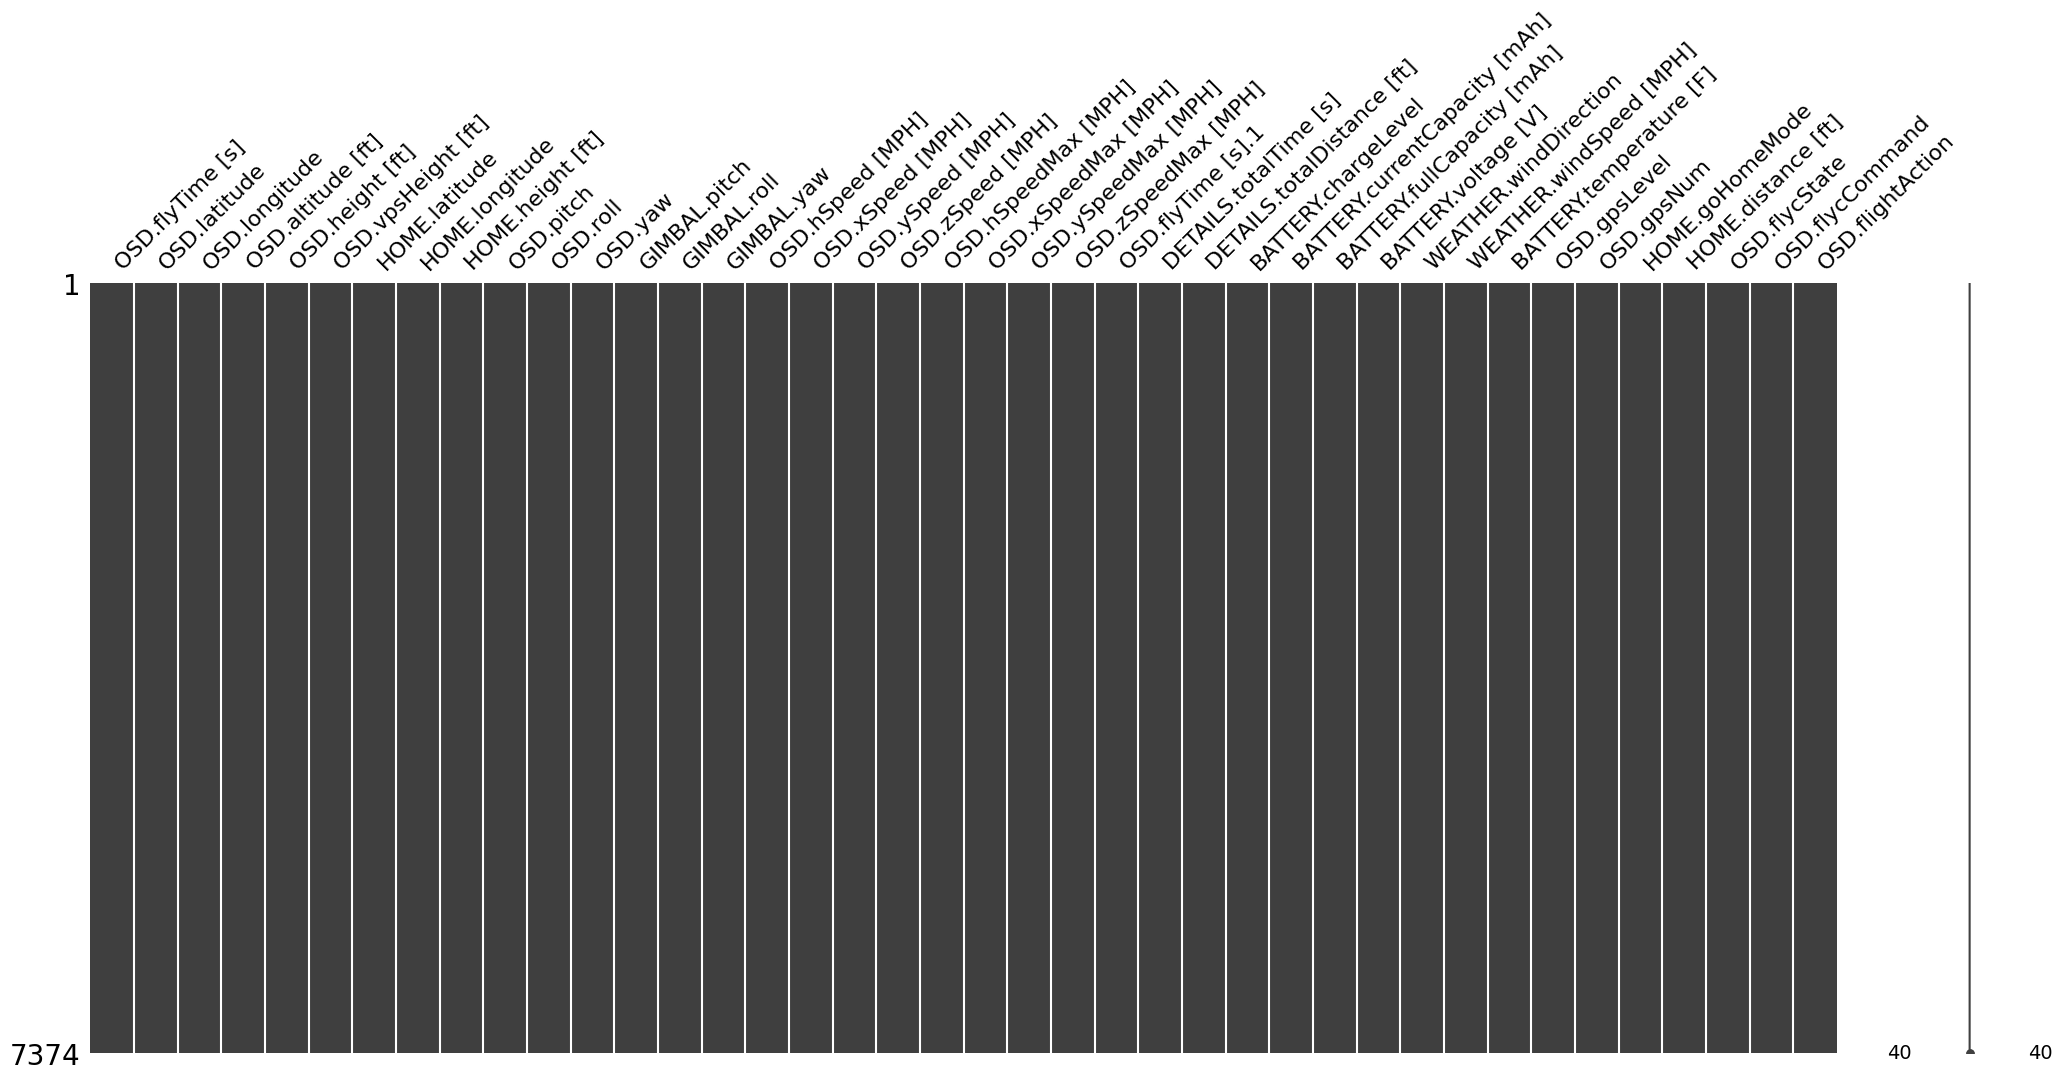

In [39]:
# %% Check for missing values
nan_counts = df.isnull().sum()
total_nan_count = nan_counts.sum()
print(f"\nTotal Missing Values in Dataset: {total_nan_count}")

import missingno as msno

# Visualize missing data
msno.matrix(df)

In [40]:
# %% Save cleaned DataFrame to CSV
df.to_csv('cleaned_data.csv', index=False)
print("Cleaned data saved have 0 null values to 'cleaned_data.csv'")


Cleaned data saved have 0 null values to 'cleaned_data.csv'



Total Missing Values in Dataset: 0


<Axes: >

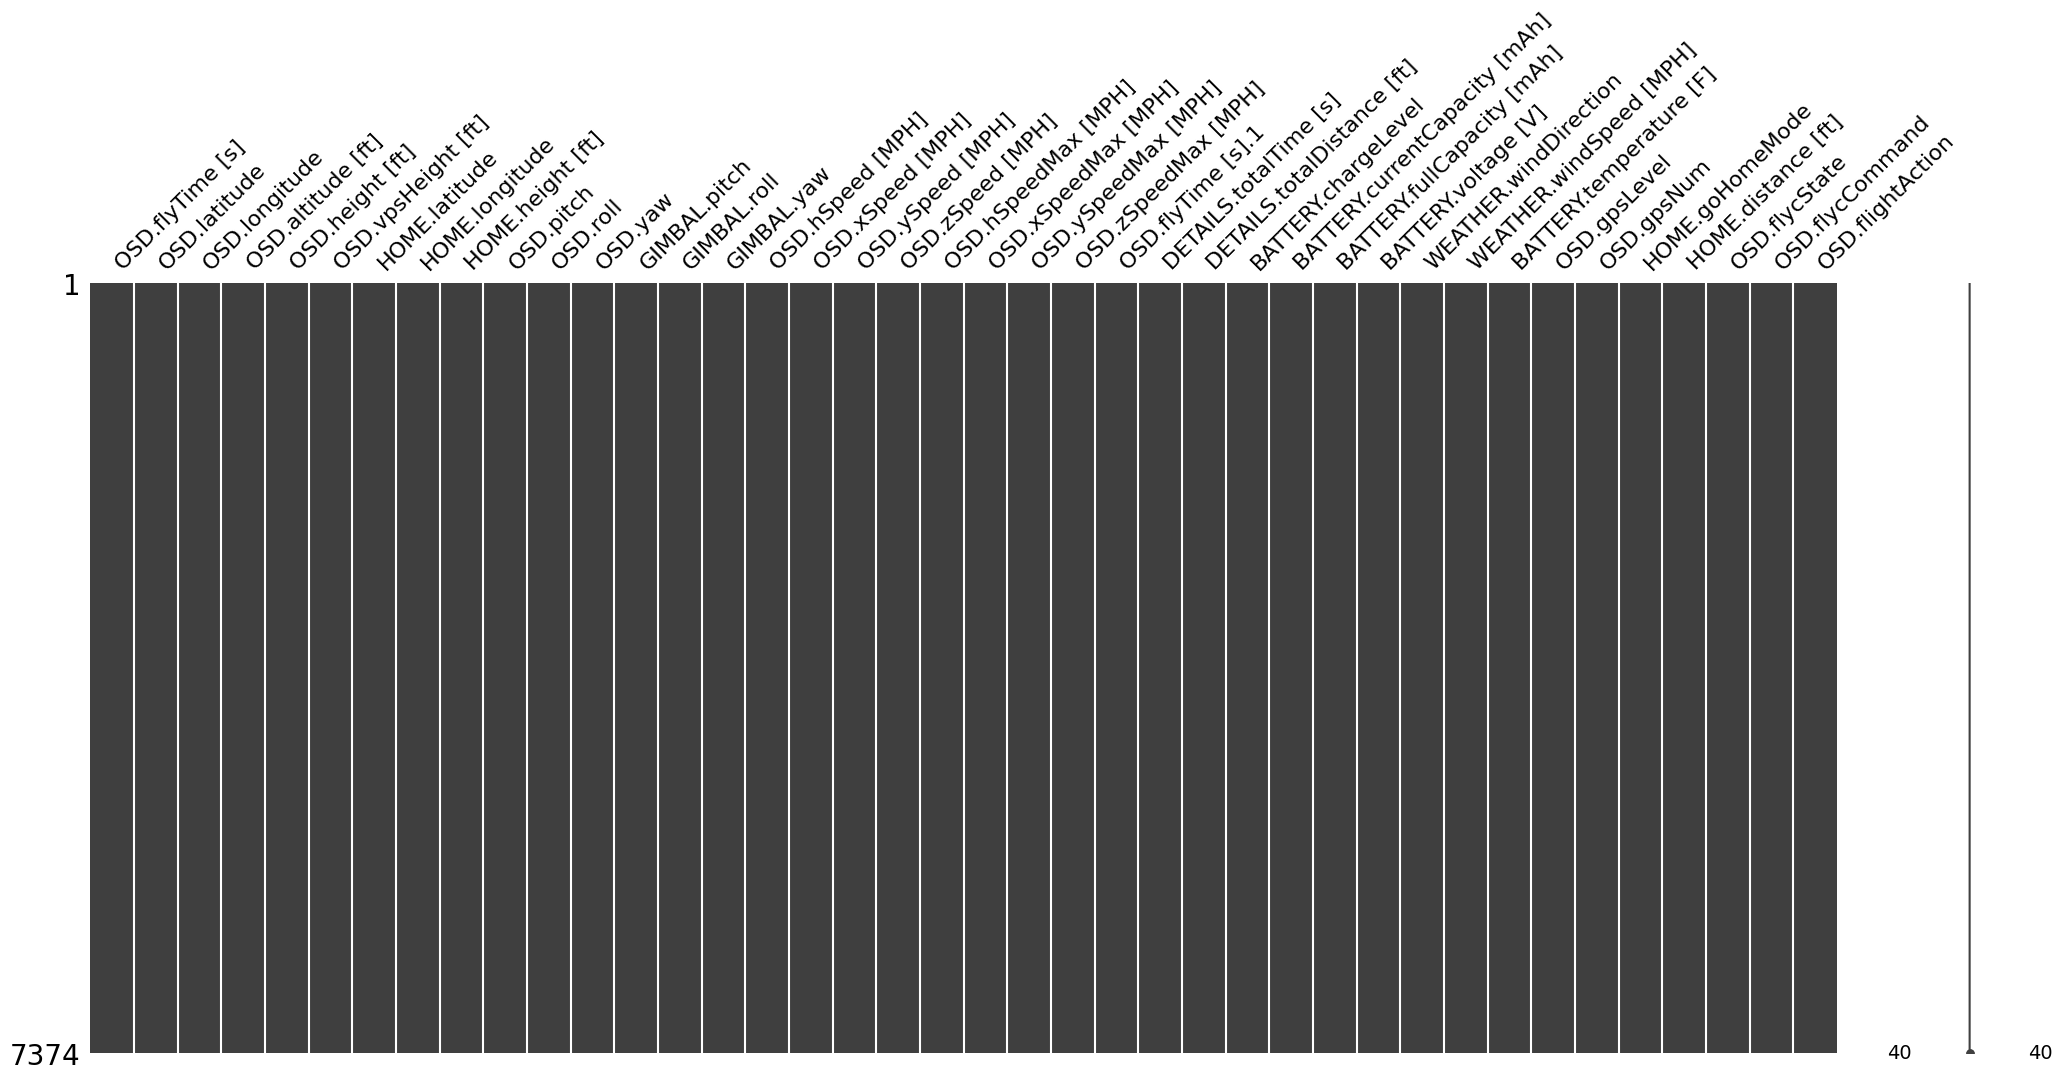

In [41]:


data1 = pd.read_csv('cleaned_data.csv')
dc = data1.select_dtypes(include=[float, int])# Filter only numerical columns
nan_counts = dc.isnull().sum()
total_nan_count = nan_counts.sum()
print(f"\nTotal Missing Values in Dataset: {total_nan_count}")

import missingno as msno

# Visualize missing data
msno.matrix(dc)



In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSD.flyTime [s]                7374 non-null   float64
 1   OSD.latitude                   7374 non-null   float64
 2   OSD.longitude                  7374 non-null   float64
 3   OSD.altitude [ft]              7374 non-null   int64  
 4   OSD.height [ft]                7374 non-null   float64
 5   OSD.vpsHeight [ft]             7374 non-null   float64
 6   HOME.latitude                  7374 non-null   float64
 7   HOME.longitude                 7374 non-null   float64
 8   HOME.height [ft]               7374 non-null   float64
 9   OSD.pitch                      7374 non-null   float64
 10  OSD.roll                       7374 non-null   float64
 11  OSD.yaw                        7374 non-null   float64
 12  GIMBAL.pitch                   7374 non-null   f

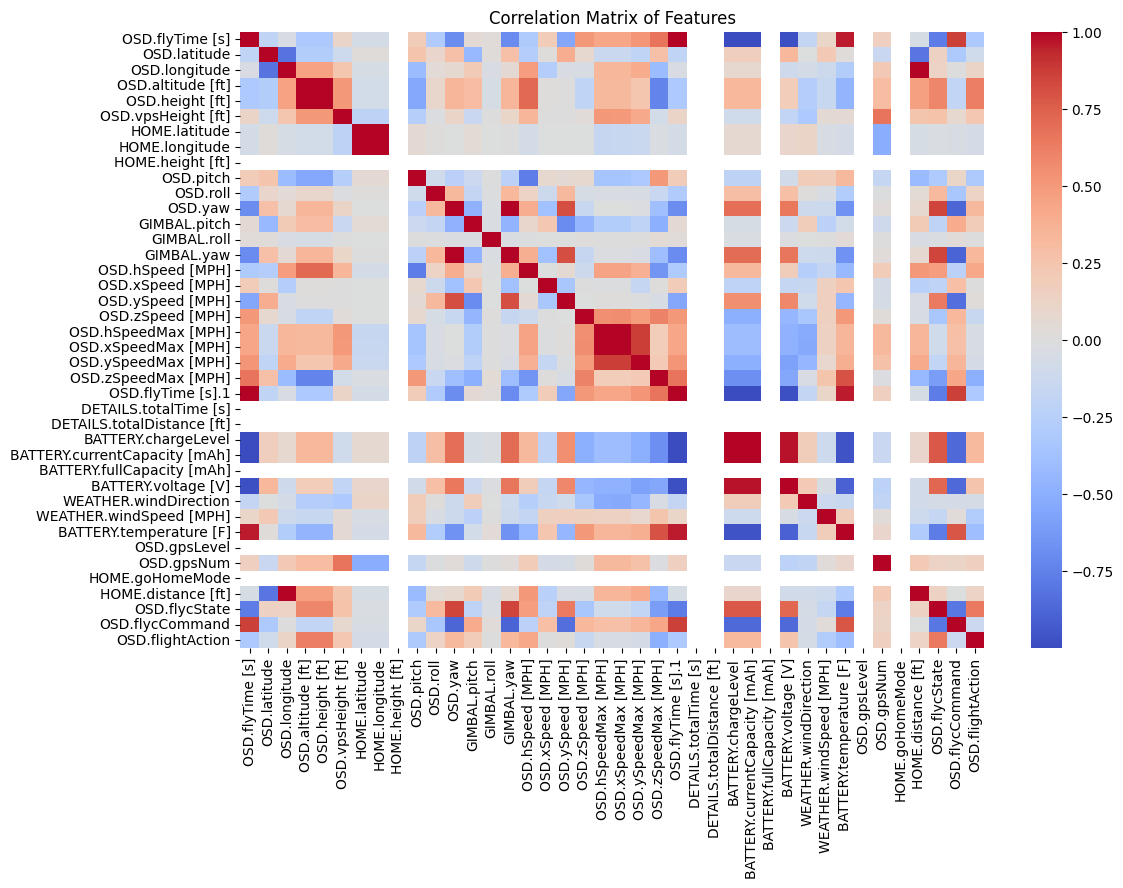


Selected features for OSD.latitude: ['OSD.longitude', 'HOME.distance [ft]']

Selected features for OSD.longitude: ['OSD.latitude', 'HOME.distance [ft]']

Selected features for OSD.altitude [ft]: ['OSD.height [ft]']


In [ ]:
# %% Correlation analysis and feature selection
corr_matrix = dc.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()
plt.savefig('correlation_matrix(6thNov).png')
plt.close()


# Set target variables
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
correlation_threshold = 0.75

# Select features highly correlated with each target
selected_features = {}
for target in target_variables:
    correlated_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
    correlated_features.remove(target)  # Remove the target itself
    selected_features[target] = correlated_features
    print(f"\nSelected features for {target}: {correlated_features}")


In [57]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSD.flyTime [s]                7374 non-null   float64
 1   OSD.latitude                   7374 non-null   float64
 2   OSD.longitude                  7374 non-null   float64
 3   OSD.altitude [ft]              7374 non-null   int64  
 4   OSD.height [ft]                7374 non-null   float64
 5   OSD.vpsHeight [ft]             7374 non-null   float64
 6   HOME.latitude                  7374 non-null   float64
 7   HOME.longitude                 7374 non-null   float64
 8   HOME.height [ft]               7374 non-null   float64
 9   OSD.pitch                      7374 non-null   float64
 10  OSD.roll                       7374 non-null   float64
 11  OSD.yaw                        7374 non-null   float64
 12  GIMBAL.pitch                   7374 non-null   f

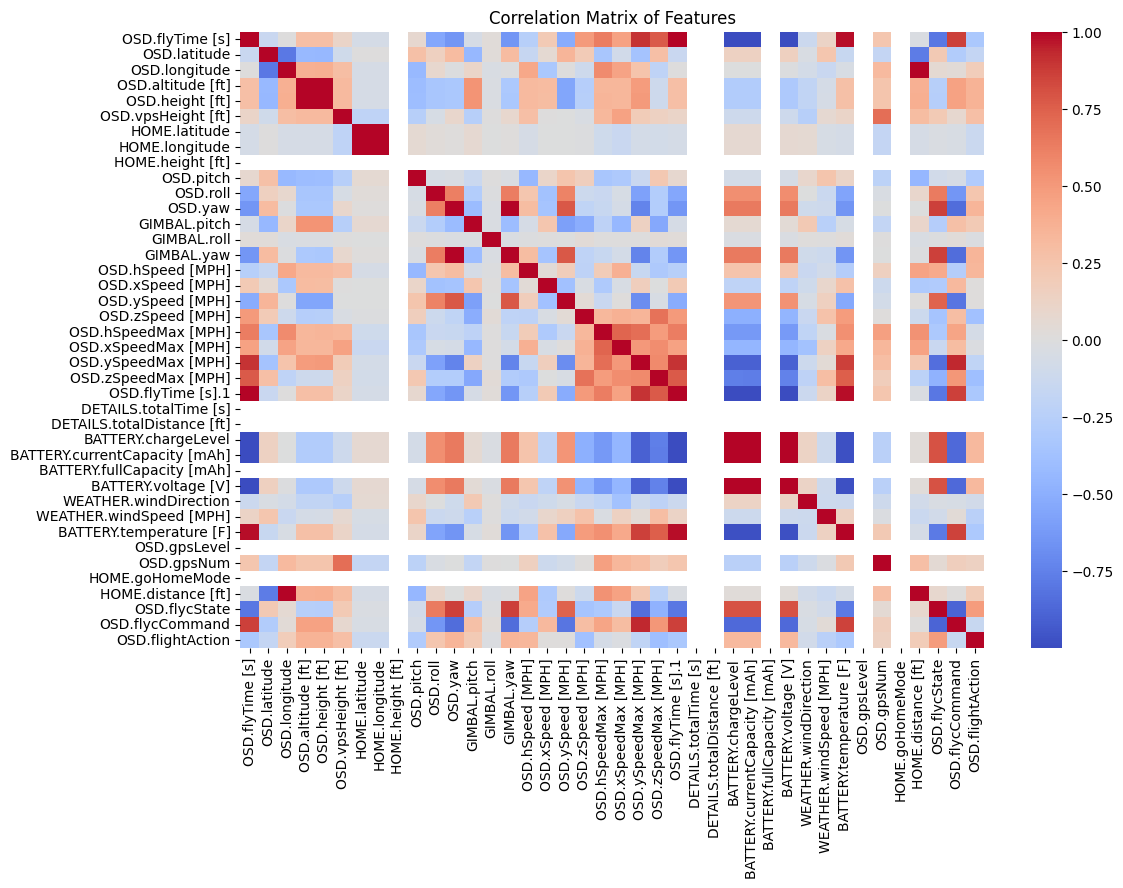


Selected features for OSD.latitude: ['OSD.longitude', 'HOME.distance [ft]']

Selected features for OSD.longitude: ['OSD.latitude', 'HOME.distance [ft]']

Selected features for OSD.altitude [ft]: ['OSD.height [ft]']


In [43]:
# %% Correlation analysis and feature selection
corr_matrix = dc.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()
plt.savefig('correlation_matrix(6thNov).png')
plt.close()


# Set target variables
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
correlation_threshold = 0.75

# Select features highly correlated with each target
selected_features = {}
for target in target_variables:
    correlated_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
    correlated_features.remove(target)  # Remove the target itself
    selected_features[target] = correlated_features
    print(f"\nSelected features for {target}: {correlated_features}")

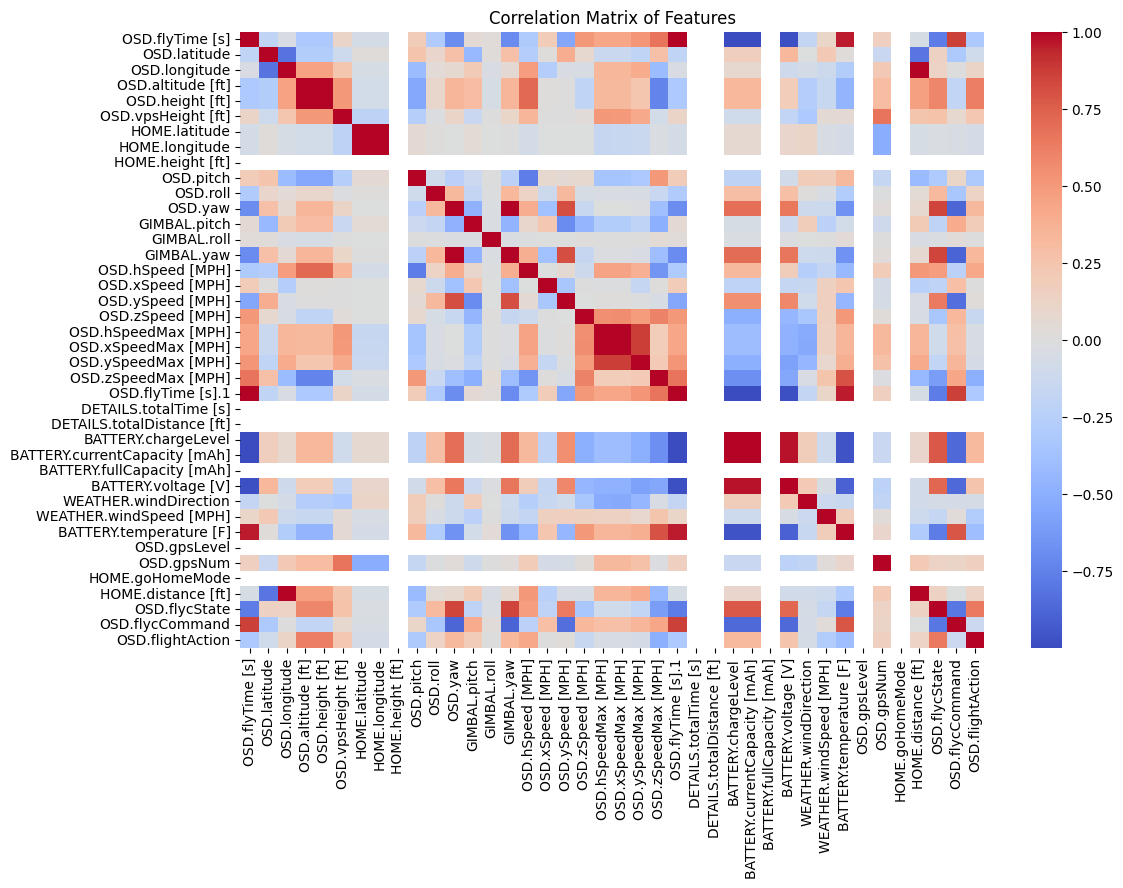


Selected features for OSD.latitude: ['OSD.longitude', 'HOME.distance [ft]']

Selected features for OSD.longitude: ['OSD.latitude', 'HOME.distance [ft]']

Selected features for OSD.altitude [ft]: ['OSD.height [ft]']


In [44]:
# %% Correlation analysis and feature selection
corr_matrix = dc.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()
plt.savefig('correlation_matrix(6thNov).png')
plt.close()


# Set target variables
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
correlation_threshold = 0.75

# Select features highly correlated with each target
selected_features = {}
for target in target_variables:
    correlated_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
    correlated_features.remove(target)  # Remove the target itself
    selected_features[target] = correlated_features
    print(f"\nSelected features for {target}: {correlated_features}")

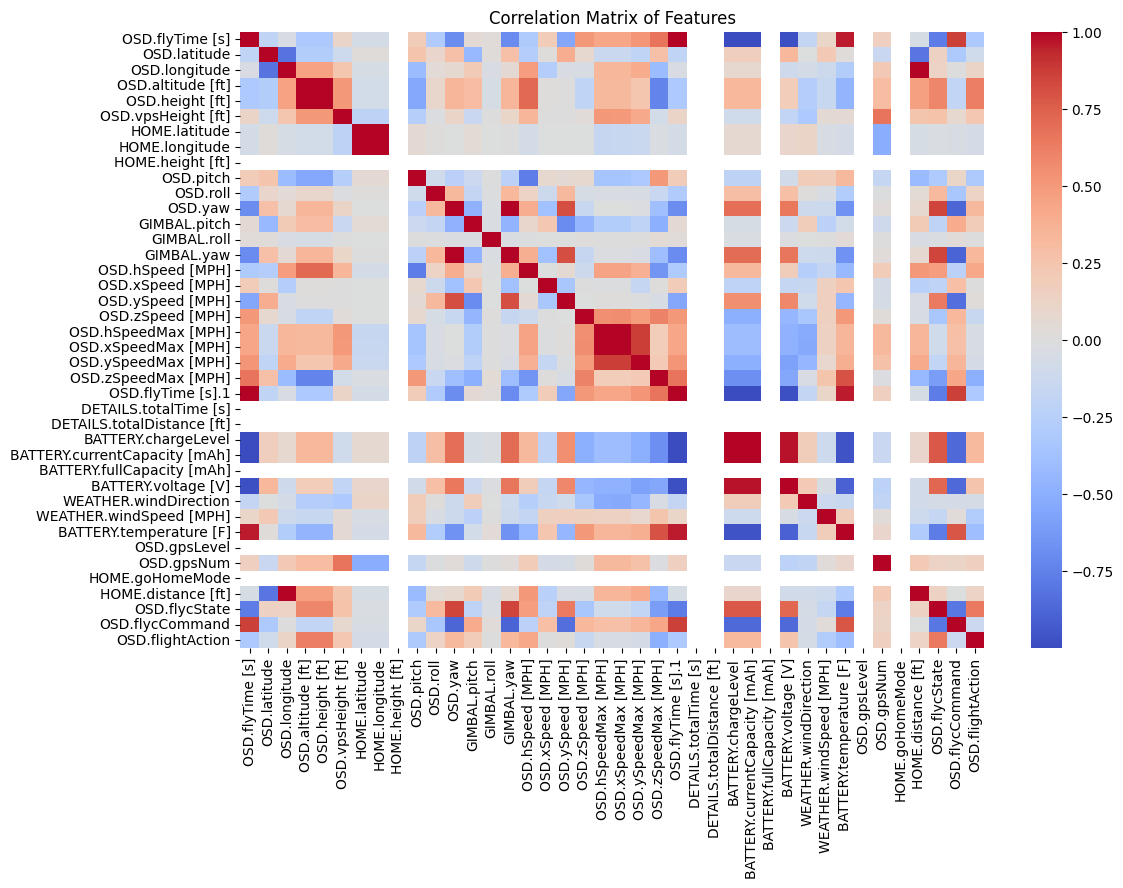


Selected features for OSD.latitude: ['OSD.longitude', 'HOME.distance [ft]']

Selected features for OSD.longitude: ['OSD.latitude', 'HOME.distance [ft]']

Selected features for OSD.altitude [ft]: ['OSD.height [ft]']


In [45]:
# %% Correlation analysis and feature selection
corr_matrix = dc.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()
plt.savefig('correlation_matrix(6thNov).png')
plt.close()


# Set target variables
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
correlation_threshold = 0.75

# Select features highly correlated with each target
selected_features = {}
for target in target_variables:
    correlated_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
    correlated_features.remove(target)  # Remove the target itself
    selected_features[target] = correlated_features
    print(f"\nSelected features for {target}: {correlated_features}")

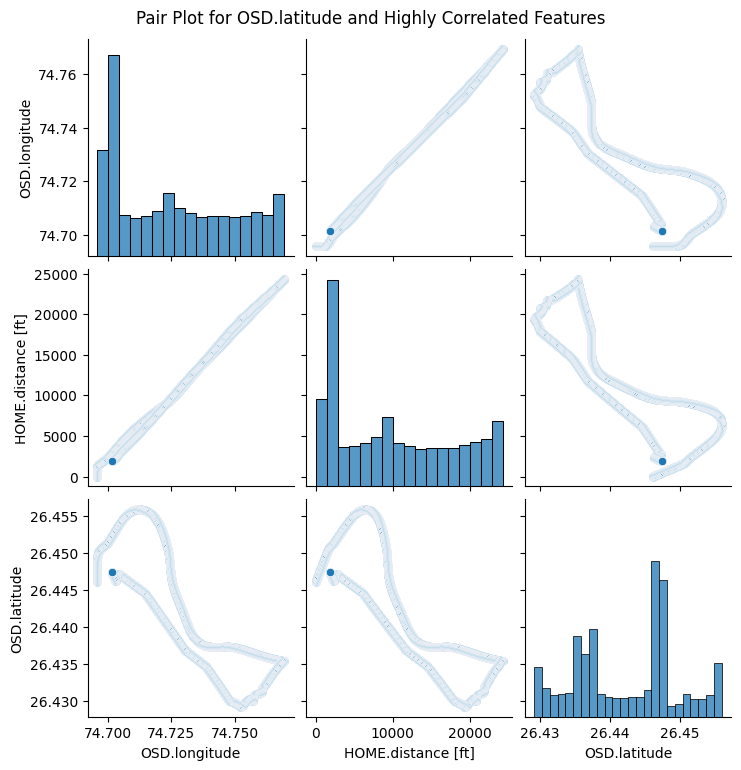

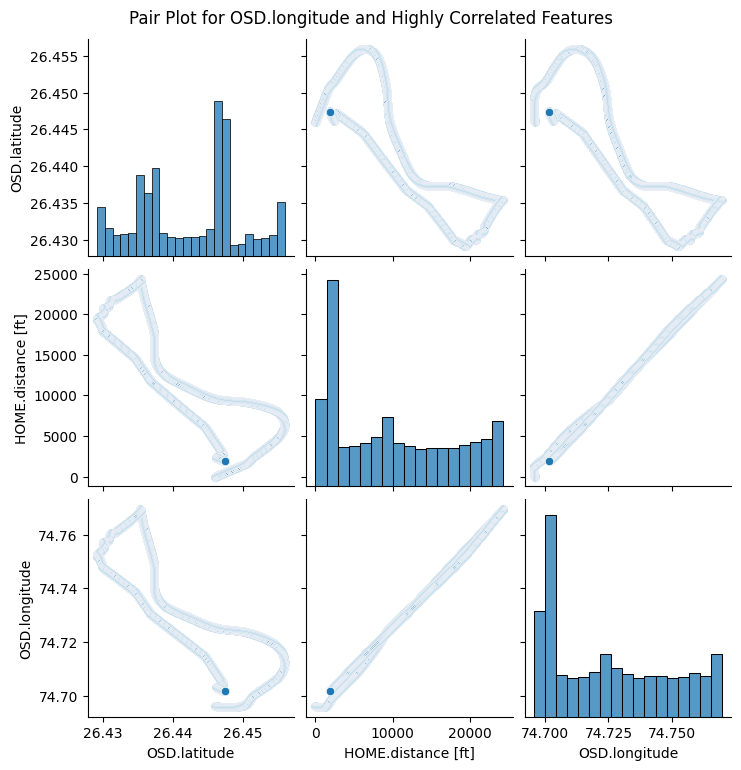

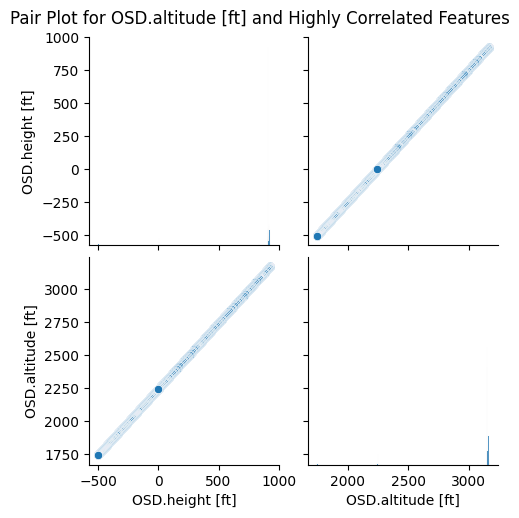

In [46]:
# %% Pair plot for correlated features with the target
for target, features in selected_features.items():
    # Add target to features list for plotting
    plot_features = features + [target]
    sns.pairplot(dc[plot_features])
    plt.suptitle(f"Pair Plot for {target} and Highly Correlated Features", y=1.02)
    plt.savefig('correlationgraph(6thNov).png')
    
    plt.show()


In [15]:
data1.columns

Index(['OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude', 'OSD.height [ft]',
       'OSD.heightMax [ft]', 'OSD.vpsHeight [ft]', 'OSD.altitude [ft]',
       'OSD.mileage [ft]', 'OSD.hSpeed [MPH]', 'OSD.hSpeedMax [MPH]',
       'OSD.xSpeed [MPH]', 'OSD.xSpeedMax [MPH]', 'OSD.ySpeed [MPH]',
       'OSD.ySpeedMax [MPH]', 'OSD.zSpeed [MPH]', 'OSD.zSpeedMax [MPH]',
       'OSD.pitch', 'OSD.roll', 'OSD.yaw', 'OSD.yaw [360]',
       'OSD.directionOfTravel', 'OSD.gpsNum', 'OSD.gpsLevel',
       'OSD.voltageWarning', 'GIMBAL.pitch', 'GIMBAL.roll', 'GIMBAL.yaw',
       'GIMBAL.yaw [360]', 'RC.downlinkSignal', 'RC.uplinkSignal',
       'RC.aileron', 'RC.elevator', 'RC.throttle', 'RC.rudder',
       'RC.wheelOffset', 'BATTERY.chargeLevel', 'BATTERY.currentPV [V]',
       'BATTERY.currentCapacity [mAh]', 'BATTERY.fullCapacity [mAh]',
       'BATTERY.voltage [V]', 'BATTERY.cellVoltage1 [V]',
       'BATTERY.cellVoltage2 [V]', 'BATTERY.cellVoltage3 [V]',
       'BATTERY.cellVoltage4 [V]', 'BATTERY.ma

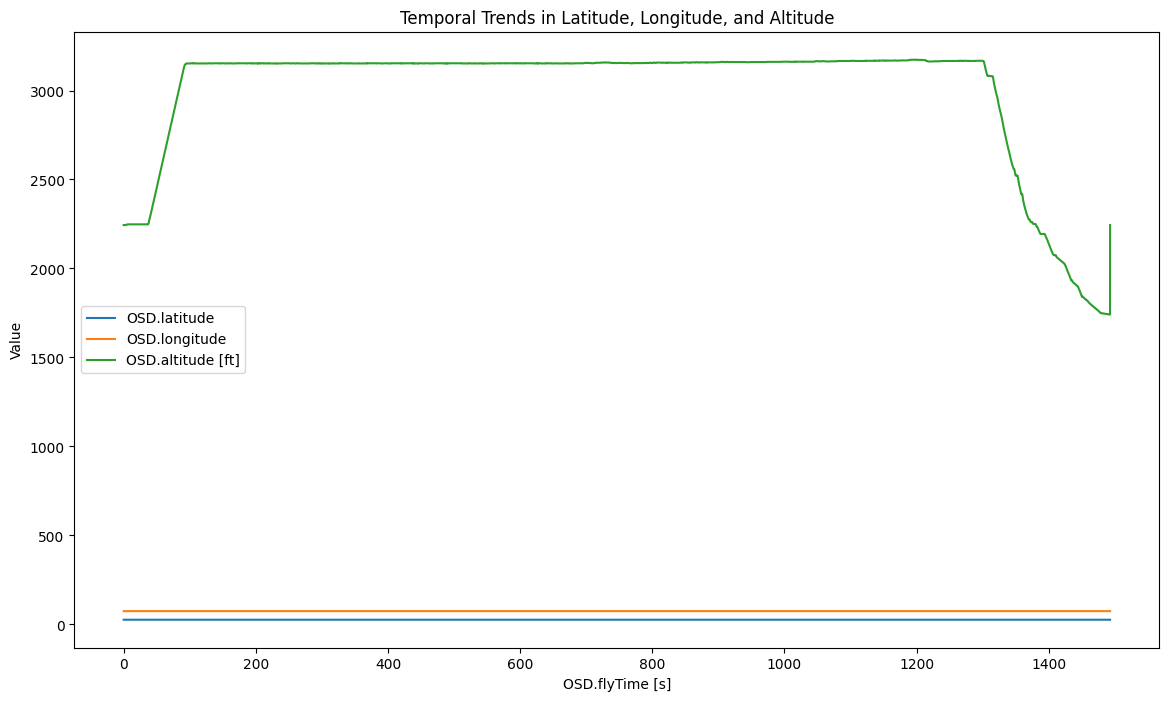

In [48]:
# %% Temporal trend visualization
#dc['timestamp'] = pd.to_datetime(data1['OSD.flyTime [s]'])  # Convert date column for plotting

plt.figure(figsize=(14, 8))
for target in target_variables:
    plt.plot(dc['OSD.flyTime [s]'], dc[target], label=target)
plt.xlabel('OSD.flyTime [s]')
plt.ylabel("Value")
plt.title("Temporal Trends in Latitude, Longitude, and Altitude")
plt.legend()
plt.savefig('temporal trends(6thNov).png')
plt.show()


In [49]:

target = 'OSD.latitude'  # Replace with your actual target column name

# Select features with high correlation with the target
correlation_threshold = 0.75
selected_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
selected_features.remove(target)  # Remove the target itself from the list
print("Selected Features:", selected_features)

Selected Features: ['OSD.longitude', 'HOME.distance [ft]']


In [50]:
target = 'OSD.longitude'  # Replace with your actual target column name

# Select features with high correlation with the target
correlation_threshold = 0.75
selected_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
selected_features.remove(target)  # Remove the target itself from the list
print("Selected Features:", selected_features)

Selected Features: ['OSD.latitude', 'HOME.distance [ft]']


In [51]:

target = 'OSD.altitude [ft]'  # Replace with your actual target column name


# Select features with high correlation with the target
correlation_threshold = 0.75
selected_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
selected_features.remove(target)  # Remove the target itself from the list
print("Selected Features:", selected_features)

Selected Features: ['OSD.height [ft]']


In [52]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSD.flyTime [s]                7374 non-null   float64
 1   OSD.latitude                   7374 non-null   float64
 2   OSD.longitude                  7374 non-null   float64
 3   OSD.altitude [ft]              7374 non-null   int64  
 4   OSD.height [ft]                7374 non-null   float64
 5   OSD.vpsHeight [ft]             7374 non-null   float64
 6   HOME.latitude                  7374 non-null   float64
 7   HOME.longitude                 7374 non-null   float64
 8   HOME.height [ft]               7374 non-null   float64
 9   OSD.pitch                      7374 non-null   float64
 10  OSD.roll                       7374 non-null   float64
 11  OSD.yaw                        7374 non-null   float64
 12  GIMBAL.pitch                   7374 non-null   f

In [58]:
nan_counts = dc.isnull().sum()
total_nan_count = nan_counts.sum()
print(f"\nTotal Missing Values in Dataset: {total_nan_count}")


Total Missing Values in Dataset: 0


In [59]:
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
selected_features= ['OSD.flyTime [s]','OSD.height [ft]','HOME.distance [ft]']



X = df[selected_features]
Y = df[target_variables]

In [60]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Initialize RFE with the model
rfe = RFE(estimator=model, n_features_to_select=3)  # Select top 5 features
rfe.fit(X, Y)  # Make sure to pass DataFrames to RFE

# Get selected features
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("Selected features:", selected_features)

# Use selected features for further modeling
X_selected = X[selected_features]  # Subset the DataFrame with selected features

Selected features: ['OSD.height [ft]']


In [61]:
# Set target variables
target_variables = ['OSD.latitude', 'OSD.longitude', 'OSD.altitude [ft]']
correlation_threshold = 0.75

# Create an empty set to store selected features
selected_features_set = set()

# Iterate through each target variable to find highly correlated features
for target in target_variables:
    # Get features that are highly correlated with the current target
    correlated_features = corr_matrix[target][corr_matrix[target].abs() > correlation_threshold].index.tolist()
    # Remove the target itself from the list of correlated features
    correlated_features.remove(target)
    # Add these correlated features to the set
    selected_features_set.update(correlated_features)

# Convert the set back to a list
selected_variables = list(selected_features_set)

# Display the selected features excluding target variables
print("Selected Variables Excluding Target Variables:")
print(selected_variables)

Selected Variables Excluding Target Variables:
['HOME.distance [ft]', 'OSD.longitude', 'OSD.latitude', 'OSD.height [ft]']


In [63]:


# Define columns to keep
selected_columns = ['OSD.flyTime [s]','HOME.distance [ft]', 'OSD.longitude', 'OSD.latitude', 'OSD.height [ft]']
# Create a new DataFrame with only the selected columns
new_df = dc[selected_columns]

# Save the new DataFrame to a new CSV file
new_df.to_csv('preprocced_dataset.csv', index=False)

print("preprocced_dataset saved as 'preprocced_dataset.csv'")


preprocced_dataset saved as 'preprocced_dataset.csv'


0          3.2
1          3.2
2          3.2
3          3.2
4          3.2
         ...  
7369    1908.7
7370    1908.7
7371    1908.7
7372    1908.7
7373    1908.7
Name: HOME.distance [ft], Length: 7374, dtype: float64